In [1]:
# Importação de bibliotecas
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

In [20]:
# Função para carregar e aplicar filtro de suavização
def load_and_preprocess_image(image_path, filter_type='gaussian'):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if filter_type == 'gaussian':
        image = cv2.GaussianBlur(image, (5, 5), 0)
    elif filter_type == 'bilateral':
        image = cv2.bilateralFilter(image, 9, 75, 75)
    elif filter_type == 'median':
        image = cv2.medianBlur(image, 5)
    return image

In [40]:
# Função para limiarização adaptativa e operações morfológicas
def apply_thresholding(image, block_size=11, c_value=2):
    thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, block_size, c_value)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    return opening


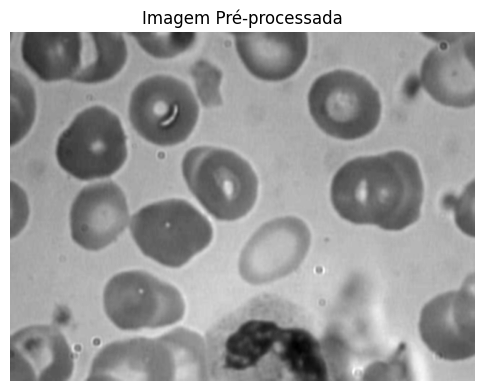

In [41]:
# Caminho para a imagem de exemplo
image_path = "/content/BloodImage_00340.jpg"

# Carregamento e pré-processamento da imagem
preprocessed_image = load_and_preprocess_image(image_path, filter_type='gaussian')

# Exibindo a imagem pré-processada
plt.figure(figsize=(6, 6))
plt.title("Imagem Pré-processada")
plt.imshow(preprocessed_image, cmap='gray')
plt.axis("off")
plt.show()

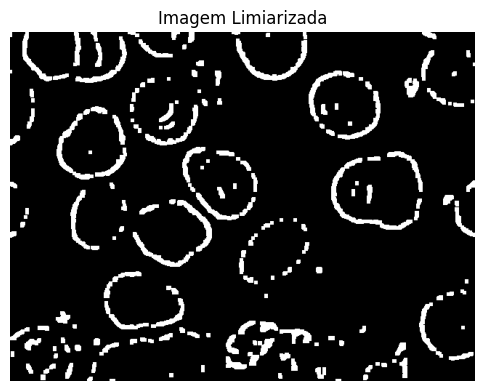

In [42]:
# Aplicação da limiarização e operações morfológicas
thresholded_image = apply_thresholding(preprocessed_image, block_size=19, c_value=2)

# Exibindo a imagem limiarizada
plt.figure(figsize=(6, 6))
plt.title("Imagem Limiarizada")
plt.imshow(thresholded_image, cmap='gray')
plt.axis("off")
plt.show()

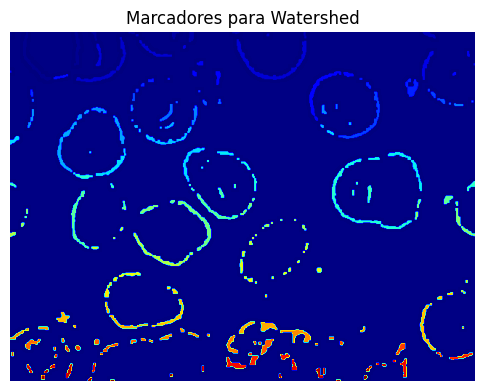

In [43]:
def get_markers(image):
    sure_bg = cv2.dilate(image, np.ones((3, 3), np.uint8), iterations=3)
    dist_transform = cv2.distanceTransform(image, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    return markers

# Obtenção dos marcadores
markers = get_markers(thresholded_image)

# Exibindo os marcadores
plt.figure(figsize=(6, 6))
plt.title("Marcadores para Watershed")
plt.imshow(markers, cmap='jet')
plt.axis("off")
plt.show()

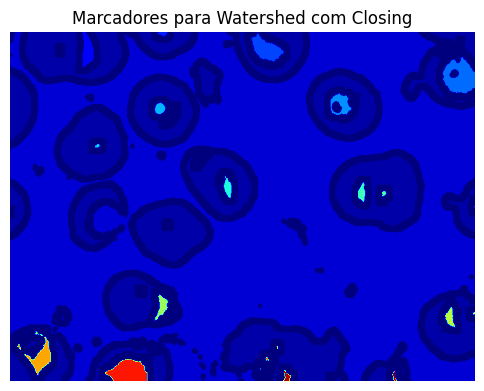

In [46]:
def get_markers(image):
    # Define a área de fundo certa
    sure_bg = cv2.dilate(image, np.ones((5, 5), np.uint8), iterations=3)

    # Aplica a Transformada de Distância para obter áreas de foreground
    dist_transform = cv2.distanceTransform(image, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.05 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Áreas desconhecidas (bordas entre fundo e foreground)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Aplicação de closing para unir bordas quebradas em foreground
    kernel = np.ones((7, 7), np.uint8)
    sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Definição dos marcadores
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    return markers

# Carrega e pré-processa a imagem em escala de cinza
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Aplica limiarização para obter uma imagem binária
_, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Obtenção dos marcadores
markers = get_markers(thresholded_image)

# Exibindo os marcadores com cmap='jet' para visualização
plt.figure(figsize=(6, 6))
plt.title("Marcadores para Watershed com Closing")
plt.imshow(markers, cmap='jet')
plt.axis("off")
plt.show()

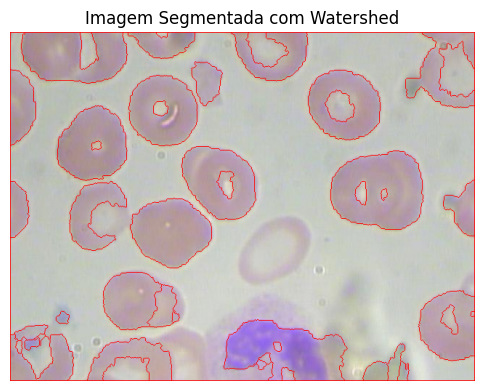

In [47]:
def apply_watershed(original_image, markers):
    markers = cv2.watershed(original_image, markers)
    segmented_image = original_image.copy()
    segmented_image[markers == -1] = [0, 0, 255]
    return segmented_image, markers

# Carrega a imagem colorida original para segmentação
original_image = cv2.imread(image_path)
segmented_image, markers = apply_watershed(original_image, markers)

# Exibindo a imagem segmentada
plt.figure(figsize=(6, 6))
plt.title("Imagem Segmentada com Watershed")
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
def calculate_cell_statistics(markers):
    unique_cells = np.unique(markers) - 1  # Exclui o marcador de fundo
    cell_areas = [np.sum(markers == cell_id) for cell_id in unique_cells if cell_id > 0]

    total_cells = len(cell_areas)
    mean_area = np.mean(cell_areas) if cell_areas else 0
    area_variance = np.var(cell_areas) if cell_areas else 0

    print(f"Total de células detectadas: {total_cells}")

    return total_cells

# Cálculo e exibição das estatísticas
total_cells = calculate_cell_statistics(markers)

Total de células detectadas: 24
